In [1]:
import os
import numpy as np
import matplotlib as mpl
import pandas as pd
import itertools
import matplotlib.pyplot as plt

In [2]:
#Load Data 
board_names=["dev_board"]
date_label ="2022-11-05"
tname = "PC & PV Network"
time_label = "15-2"
dir_path = f"./data/{tname}/{date_label}"
config_path = f"{dir_path}/config"
network_output=np.load(f"{dir_path}/pc_pv_sst{time_label}.npy" )
times=network_output[1]-network_output[1][0]
spike_id=network_output[0]
#Neuron numbers
nvn=1
pvn=10
pcn=80
sstn=10
in_freq=700
#

pc_id=spike_id[(spike_id>nvn+1)&(spike_id<nvn+1+pcn)]
pc_times=times[(spike_id>nvn+1)&(spike_id<nvn+1+pcn)]

pv_id=spike_id[(spike_id>nvn+1+pcn)&(spike_id<nvn+2+pcn+pvn)]
pv_times=times[(spike_id>nvn+1+pcn)&(spike_id<nvn+2+pcn+pvn)]

sst_id=spike_id[(spike_id>nvn+2+pcn+pvn)&(spike_id<nvn+3+pcn+pvn+sstn)]
sst_times=times[(spike_id>nvn+2+pcn+pvn)&(spike_id<nvn+3+pcn+pvn+sstn)]

input_id=spike_id[spike_id==0]
input_time=times[spike_id==0]
#Set_up_parameters

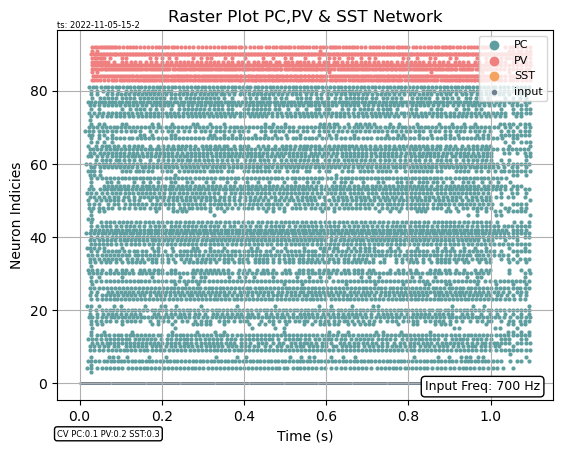

In [3]:

# Generate data...
from ctypes import c_void_p
network_output=np.asanyarray(network_output)
times=network_output[1]-network_output[1][0]
spike_id=np.asanyarray(network_output[0],dtype=np.uint8)


if pcn>0:
    pc_id=spike_id[(spike_id>nvn+1)&(spike_id<nvn+1+pcn)]
    pc_times=times[(spike_id>nvn+1)&(spike_id<nvn+1+pcn)]
else:
    pc_id=[]
    pc_times=[]

if pvn>0:
    pv_id=spike_id[(spike_id>nvn+1+pcn)&(spike_id<nvn+2+pcn+pvn)]
    pv_times=times[(spike_id>nvn+1+pcn)&(spike_id<nvn+2+pcn+pvn)]
else:
    pv_id=[]
    pv_times=[]

if sstn>0:
    sst_id=spike_id[(spike_id>nvn+2+pcn+pvn)&(spike_id<nvn+3+pcn+pvn+sstn)]
    sst_times=times[(spike_id>nvn+2+pcn+pvn)&(spike_id<nvn+3+pcn+pvn+sstn)]
else:
    sst_id=[]
    sst_times=[]

input_id=spike_id[spike_id==0]
input_time=times[spike_id==0]

cv_values=[.1,.2,.3]
plt.figure()
plt.scatter(pc_times,pc_id,c='cadetblue',s=4,label='PC')
plt.scatter(pv_times,pv_id,c='lightcoral',s=4,label='PV')
plt.scatter(sst_times,sst_id,c='sandybrown',s=4,label='SST')
plt.scatter(input_time,input_id,c='slategray',s=1,label='input')
plt.figtext(0.7, 0.13,'Input Freq: '+str(in_freq)+' Hz', size=9,bbox=dict(boxstyle="round", fc="w"))
plt.xlabel('Time (s)')
plt.ylabel('Neuron Indicies')
plt.grid()
plt.title('Raster Plot PC,PV & SST Network',fontsize=12)
annotation_string = f"ts: {date_label}-{time_label}"
plt.text(0,1.025, annotation_string,transform=plt.gca().transAxes, va = "top", ha="left",fontsize=6)
annotation_string = f"CV PC:{cv_values[0]} PV:{cv_values[1]} SST:{cv_values[2]}"
plt.text(0,-.08, annotation_string,transform=plt.gca().transAxes, va = "top", ha="left",fontsize=6,bbox=dict(boxstyle="round", fc="w"))
# Plot legend.
lgnd = plt.legend(loc="upper right", numpoints=1, fontsize=8,markerscale=3)

plt.show()
plt.close()


In [4]:
def split_spike_indices_by_window(times, indices, window_size:int, total_duration:int):
	"""
	Split a list of spike indices (with accompanying spike times) into bins 
	based on equal length time windows.
	"""
	return np.split(indices, np.sum(np.atleast_2d(times) < np.atleast_2d(np.arange(window_size,total_duration,window_size)).T, axis=1))

In [5]:
def spike_train_synchrony_correlation(spike_times, spike_indices, total_duration:int):
	"""
	Calculate the average correlation between the windowed spike counts for all pairs
	of neurons in the network.
	Returns NaN if no neurons fired. Returns 0 if only one neuron fired.

	"""
	if len(spike_indices) == 0:
		return np.nan
	elif len(spike_indices) == 1:
		return 0
	
	neuron_indices = np.unique(spike_indices)
	num_neurons = len(neuron_indices)
	windowed_spikes = split_spike_indices_by_window(spike_times, spike_indices, .1, total_duration)
	windowed_spike_counts = np.zeros((1+np.max(neuron_indices), len(windowed_spikes)))

	for i, window in enumerate(windowed_spikes):
		spike_indices, spike_counts = np.unique(window, return_counts=True)
		windowed_spike_counts[spike_indices, i] = spike_counts
	
	# only calculate the correlations for spike trains where we have spikes
	spiking_neuron_spike_trains = windowed_spike_counts[neuron_indices,:]
	if spiking_neuron_spike_trains.shape[0] > 1:
		correlation_coefficients = np.tril(np.corrcoef(spiking_neuron_spike_trains), k=-1)
		num_coefficients = num_neurons*(num_neurons-1) / 2
		# on the off chance that a spike train is perfectly regular, correlating with it will
		# result in a NaN value - remove these
		return np.nansum(correlation_coefficients) / (num_coefficients - np.count_nonzero(np.isnan(correlation_coefficients)))
	else:
		# we only have one neuron spike train - no synchronisation
		return 0.0

In [6]:
PC_synchrony = spike_train_synchrony_correlation(pc_times,pc_id,times[-1])
print(PC_synchrony)


0.20112779988389218


In [7]:
print(times)

[0.       0.002506 0.005012 ... 1.096884 1.097236 1.097256]


In [8]:
spike_indices=pc_id
spike_times=pc_times
total_dutation=1e6
print(spike_indices)
print(spike_times)

neuron_indices = np.unique(spike_indices)
print(neuron_indices)
num_neurons = len(neuron_indices)
print(num_neurons)
windowed_spikes = split_spike_indices_by_window(spike_times, spike_indices, .001, 1)
print(windowed_spikes)
windowed_spike_counts = np.zeros((1+np.max(neuron_indices), len(windowed_spikes)))

for i, window in enumerate(windowed_spikes):
    spike_indices, spike_counts = np.unique(window, return_counts=True)
    windowed_spike_counts[spike_indices, i] = spike_counts

# only calculate the correlations for spike trains where we have spikes
spiking_neuron_spike_trains = windowed_spike_counts[neuron_indices,:]
if spiking_neuron_spike_trains.shape[0] > 1:
    correlation_coefficients = np.tril(np.corrcoef(spiking_neuron_spike_trains), k=-1)
    num_coefficients = num_neurons*(num_neurons-1) / 2
    # on the off chance that a spike train is perfectly regular, correlating with it will
    # result in a NaN value - remove these
    print(np.nansum(correlation_coefficients) / (num_coefficients - np.count_nonzero(np.isnan(correlation_coefficients))))
else:
    # we only have one neuron spike train - no synchronisation
    print('one neouron')

[69 41 60 ... 66 18 70]
[0.01342  0.015729 0.016251 ... 1.095532 1.095604 1.097256]
[ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79 80 81]
78
[array([], dtype=uint8), array([], dtype=uint8), array([], dtype=uint8), array([], dtype=uint8), array([], dtype=uint8), array([], dtype=uint8), array([], dtype=uint8), array([], dtype=uint8), array([], dtype=uint8), array([], dtype=uint8), array([], dtype=uint8), array([], dtype=uint8), array([], dtype=uint8), array([69], dtype=uint8), array([], dtype=uint8), array([41], dtype=uint8), array([60], dtype=uint8), array([37, 52,  4], dtype=uint8), array([], dtype=uint8), array([21,  6], dtype=uint8), array([35, 45, 62, 77, 50, 58, 31], dtype=uint8), array([65, 12, 18], dtype=uint8), array([74, 81, 53, 68], dtype=uint8), array([70, 69, 30, 49, 48], dtype=uint8), array([

In [10]:
spike_indices=pc_id
spike_times=pc_times
total_dutation=1e6

x=np.split(spike_indices, np.sum(np.atleast_2d(spike_times) < np.atleast_2d(np.arange(2,1,2)).T, axis=1))
len(x[0])

6021

In [20]:

split_spike_indices_by_window(pc_times, pc_id, .002, times[-1])

[array([], dtype=uint8),
 array([], dtype=uint8),
 array([], dtype=uint8),
 array([], dtype=uint8),
 array([], dtype=uint8),
 array([], dtype=uint8),
 array([69], dtype=uint8),
 array([41], dtype=uint8),
 array([60, 37, 52,  4], dtype=uint8),
 array([21,  6], dtype=uint8),
 array([35, 45, 62, 77, 50, 58, 31, 65, 12, 18], dtype=uint8),
 array([74, 81, 53, 68, 70, 69, 30, 49, 48], dtype=uint8),
 array([34, 19, 10, 64, 76, 39, 57, 33, 41, 24, 26,  9, 51, 20, 60],
       dtype=uint8),
 array([37, 63, 72, 38,  7, 59, 17, 66,  5, 16, 47, 73, 54, 28, 14,  3, 80,
        36, 42, 32, 52, 21, 23, 56, 55, 75], dtype=uint8),
 array([ 4, 67, 29,  6, 58, 44, 25, 77, 40, 13, 71, 62, 43, 79, 46, 78, 35,
        11, 27, 45], dtype=uint8),
 array([12, 31, 18, 15, 68, 81, 30], dtype=uint8),
 array([70, 69, 64, 53, 48], dtype=uint8),
 array([41, 34, 10, 39, 74, 49,  9, 76, 26, 51, 57, 37], dtype=uint8),
 array([59, 58, 63, 33, 38, 77, 60,  6], dtype=uint8),
 array([42, 24, 50, 65], dtype=uint8),
 array([1

In [12]:
spike_indices=pc_id
spike_times=pc_times
total_dutation=1e6
print('spike indicies')
print(spike_indices)
print('spike indicies')
print(spike_times)

spike indicies
[69 41 60 ... 66 18 70]
spike indicies
[0.01342  0.015729 0.016251 ... 1.095532 1.095604 1.097256]


In [13]:

neuron_indices = np.unique(spike_indices)
print('unique neuron indices')
print(neuron_indices)
num_neurons = len(neuron_indices)
print('number of neurons')
print(num_neurons)
print('windowed_spikes')
windowed_spikes = split_spike_indices_by_window(spike_times, spike_indices, .01, 1)
print(windowed_spikes)
windowed_spike_counts = np.zeros((1+np.max(neuron_indices), len(windowed_spikes)))




unique neuron indices
[ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79 80 81]
number of neurons
78
windowed_spikes
[array([], dtype=uint8), array([69, 41, 60, 37, 52,  4, 21,  6], dtype=uint8), array([35, 45, 62, 77, 50, 58, 31, 65, 12, 18, 74, 81, 53, 68, 70, 69, 30,
       49, 48, 34, 19, 10, 64, 76, 39, 57, 33, 41, 24, 26,  9, 51, 20, 60,
       37, 63, 72, 38,  7, 59, 17, 66,  5, 16, 47, 73, 54, 28, 14,  3, 80,
       36, 42, 32, 52, 21, 23, 56, 55, 75,  4, 67, 29,  6, 58, 44, 25, 77,
       40, 13, 71, 62, 43, 79, 46, 78, 35, 11, 27, 45], dtype=uint8), array([12, 31, 18, 15, 68, 81, 30, 70, 69, 64, 53, 48, 41, 34, 10, 39, 74,
       49,  9, 76, 26, 51, 57, 37, 59, 58, 63, 33, 38, 77, 60,  6, 42, 24,
       50, 65], dtype=uint8), array([17, 61, 20, 52, 81, 28, 12, 18, 56, 19, 73, 31, 80, 30, 23, 66, 62

In [14]:
print('windowed_spike_counts')
print(windowed_spike_counts)
np.savetxt('data.csv', windowed_spike_counts, delimiter=',')

windowed_spike_counts
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [15]:
for i, window in enumerate(windowed_spikes):
    spike_indices, spike_counts = np.unique(window, return_counts=True)
    windowed_spike_counts[spike_indices, i] = spike_counts

print(windowed_spike_counts)

[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  1. ...  1.  1.  8.]
 [ 0.  0.  1. ...  1.  1. 10.]
 [ 0.  0.  1. ...  1.  1. 11.]]


In [16]:

spiking_neuron_spike_trains = windowed_spike_counts[neuron_indices,:]
print(spiking_neuron_spike_trains)

win

[[ 0.  0.  1. ...  0.  0.  0.]
 [ 0.  1.  1. ...  1.  1.  5.]
 [ 0.  0.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  1. ...  1.  1.  8.]
 [ 0.  0.  1. ...  1.  1. 10.]
 [ 0.  0.  1. ...  1.  1. 11.]]


NameError: name 'win' is not defined

In [ ]:


if spiking_neuron_spike_trains.shape[0] > 1:
    correlation_coefficients = np.tril(np.corrcoef(spiking_neuron_spike_trains), k=-1)
    num_coefficients = num_neurons*(num_neurons-1) / 2
    print(num_coefficients)
    # on the off chance that a spike train is perfectly regular, correlating with it will
    # result in a NaN value - remove these
    print(np.nansum(correlation_coefficients) / (num_coefficients - np.count_nonzero(np.isnan(correlation_coefficients))))
else:
    # we only have one neuron spike train - no synchronisation
    print('one neouron')

3003.0
0.6125906814106545


In [17]:
correlation_coefficients[4]

array([0.27691572, 0.44702101, 0.27691572, 0.57961571, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [18]:

# Let's measure execution time too
import time
start = time.time()

# Defining 3-dimensional hyperparameter space as a Python dictionary
hyperparameter_space = {'max_depth':[2,3,4,6,8,10,12,15,20], 
                        'min_samples_leaf':[1,2,4,6,8,10,20,30],
                        'min_samples_split':[1,2,3,4,5,6,8,10]}

from sklearn.model_selection import RandomizedSearchCV
rs = RandomizedSearchCV(dtclf, param_distributions=hyperparameter_space,
                        n_iter=10, scoring="accuracy", random_state=0,
                        n_jobs=-1, cv=10, return_train_score=True)

rs.fit(X_train, y_train)
print("Optimal hyperparameter combination:", rs.best_params_)
print()
print("Mean cross-validated training accuracy score:",
      rs.best_score_)
rs.best_estimator_.fit(X_train, y_train)
y_pred = rs.best_estimator_.predict(X_test) # Predictions
y_true = y_test # True values

print("Test accuracy:", np.round(accuracy_score(y_true, y_pred), 2))
cf_matrix = confusion_matrix(y_true, y_pred)
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(cf_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')

end = time.time()
diff = end - start
print('Execution time of Random Search (in Seconds):', diff)
print()

NameError: name 'dtclf' is not defined